### 4.2.1 Dataset Analysis and Preprocessing (10 Marks)

In [3]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print(os.listdir())

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
['wandb', '.virtual_documents', 'state.db', 'data']


In [4]:
data_path = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

df = pd.read_csv(data_path)


Batch shapes:
Images: torch.Size([32, 1, 28, 28])
Labels: torch.Size([32])


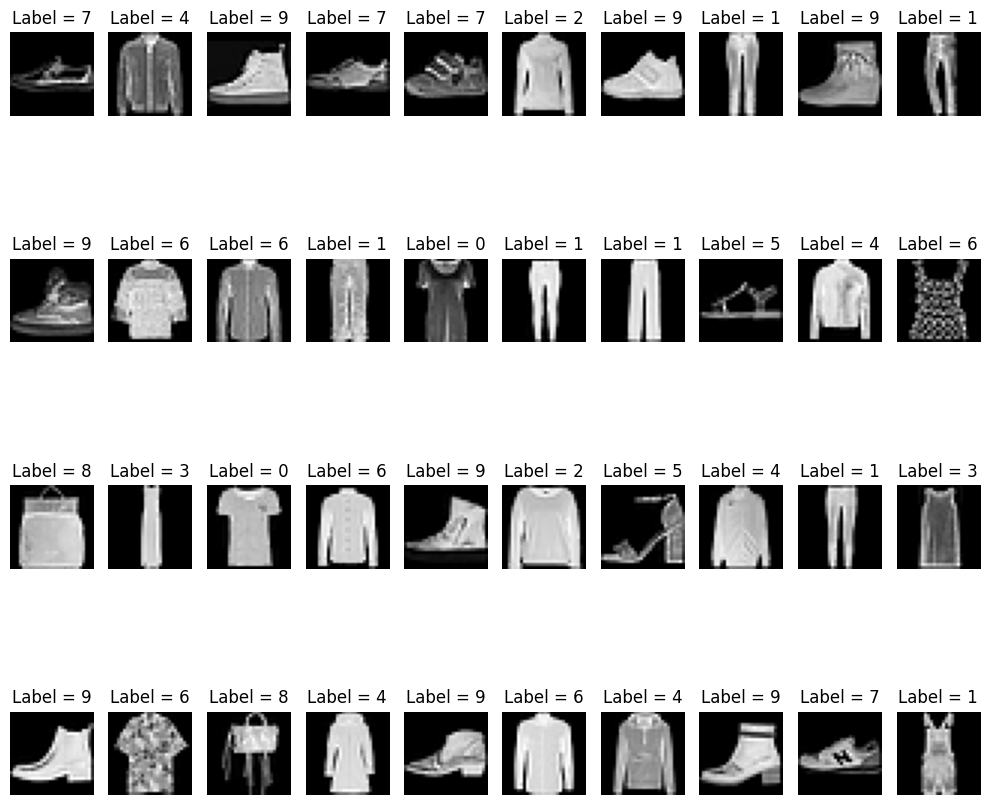

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def arrange_into_images(data):
    return data.values.reshape(-1, 28, 28, 1)

class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

def prepare_data_loaders(X, y, batch_size=32):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33)

    X_train = torch.Tensor(arrange_into_images(X_train)).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
    X_val = torch.Tensor(arrange_into_images(X_val)).permute(0, 3, 1, 2)
    X_test = torch.Tensor(arrange_into_images(X_test)).permute(0, 3, 1, 2)

    y_train = torch.Tensor(y_train.values).long()
    y_val = torch.Tensor(y_val.values).long()
    y_test = torch.Tensor(y_test.values).long()

    train_dataset = ImageDataset(X_train, y_train)
    val_dataset = ImageDataset(X_val, y_val)
    test_dataset = ImageDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

X = df.drop('label', axis=1)
y = df['label']

train_loader, val_loader, test_loader = prepare_data_loaders(X, y, batch_size=32)

for images, labels in train_loader:
    print(f"\nBatch shapes:")
    print(f"Images: {images.shape}")  
    print(f"Labels: {labels.shape}")  
    break

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.33)

def arrange_into_images(data):
    return data.values.reshape(-1, 28, 28, 1)

images = arrange_into_images(X_train.iloc[:40])

plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    plt.subplot(4, 10, i + 1)  
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title(f"Label = {y_train.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

from the images we can match the clothing types with the labels, they are as follows:
- **Label-0** : tshirts and tops 
- **Label-1** : pants
- **Label-2** : pullover(honestly 2 and 6 look very similar)
- **Label-3** : sleeveless/frock
- **Label-4** : overcoat without hood
- **Label-5** : heels/sandals
- **Label-6** : shirts
- **Label-7** : shoes
- **Label-8** : bags
- **Label-9** : ankle length shoes 

In [6]:
images = arrange_into_images(X_train)
print(type(images),images.shape)

<class 'numpy.ndarray'> (7000, 28, 28, 1)


### 4.2.2 Implement CNN Class

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class CnnAutoencoder(nn.Module):
    def __init__(self):
        super(CnnAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),    # Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   # Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                     # Output: (32, 14, 14)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                     # Output: (64, 7, 7)
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),   # Output: (32, 7, 7)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),   # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),    # Output: (1, 28, 28)
            nn.Sigmoid()
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

    def train_model(self, train_loader, num_epochs=10, learning_rate=0.001):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses = []
        self.train()
        
        for epoch in range(num_epochs):
            epoch_loss = 0
            batch_count = 0
            
            for data, _ in train_loader:
                data = data.to(next(self.parameters()).device)
                
                # Normalize input data to [0,1]
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self.forward(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)  
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
                
                if batch_count % 100 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_count}], Loss: {loss.item():.6f}")
            
            avg_epoch_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_epoch_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.6f}")
            
            scheduler.step(avg_epoch_loss)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


def visualize_reconstructions(model, test_loader, num_images=5):
    """
    Visualize original and reconstructed images side by side with proper dimension handling
    """
    model.eval()
    device = next(model.parameters()).device
    
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    images = images[:num_images]
    
    images = images.to(device)
    
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        reconstructed, _ = model(images)
    
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Original vs Reconstructed Images', fontsize=16)
    
    for i in range(num_images):
        if images[i].shape[0] == 1: 
            orig_img = images[i].squeeze(0) 
        else:
            orig_img = images[i]
        axes[0, i].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        if reconstructed[i].shape[0] == 1:  
            recon_img = reconstructed[i].squeeze(0)
        else:
            recon_img = reconstructed[i]
        axes[1, i].imshow(recon_img, cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original image shape: {images[0].shape}")
    print(f"Reconstructed image shape: {reconstructed[0].shape}")

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Batch [100], Loss: 0.010433
Epoch [1/10], Batch [200], Loss: 0.008435
Epoch [1/10], Average Loss: 0.016041
Epoch [2/10], Batch [100], Loss: 0.006269
Epoch [2/10], Batch [200], Loss: 0.005072
Epoch [2/10], Average Loss: 0.006801
Epoch [3/10], Batch [100], Loss: 0.006473
Epoch [3/10], Batch [200], Loss: 0.004033
Epoch [3/10], Average Loss: 0.005421
Epoch [4/10], Batch [100], Loss: 0.005126
Epoch [4/10], Batch [200], Loss: 0.004125
Epoch [4/10], Average Loss: 0.004692
Epoch [5/10], Batch [100], Loss: 0.003562
Epoch [5/10], Batch [200], Loss: 0.003883
Epoch [5/10], Average Loss: 0.004085
Epoch [6/10], Batch [100], Loss: 0.005509
Epoch [6/10], Batch [200], Loss: 0.003913
Epoch [6/10], Average Loss: 0.003912
Epoch [7/10], Batch [100], Loss: 0.003300
Epoch [7/10], Batch [200], Loss: 0.003141
Epoch [7/10], Average Loss: 0.003429
Epoch [8/10], Batch [100], Loss: 0.004447
Epoch [8/10], Batch [200], Loss: 0.002986
Epoch [8/10], Average Loss: 0.003214
Epoch [9/10], Batch [100], Loss:

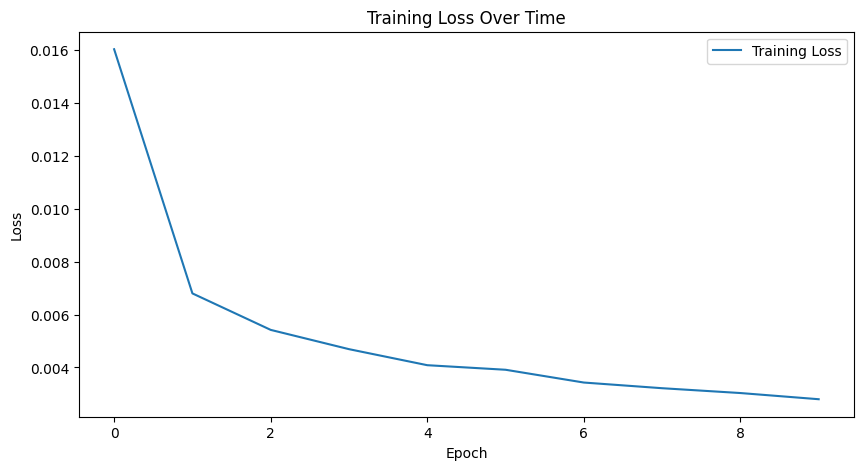

In [8]:
model = CnnAutoencoder()

model = CnnAutoencoder().to('cuda' if torch.cuda.is_available() else 'cpu')

model.train_model(train_loader, num_epochs=10, learning_rate=0.001)

### 4.2.3 Plots and Visualizations (15 Marks)

#### 1. Visualize 10 images (original and reconstructed) from the test dataset to evaluate the quality of the autoencoder’s output. (5 Marks)

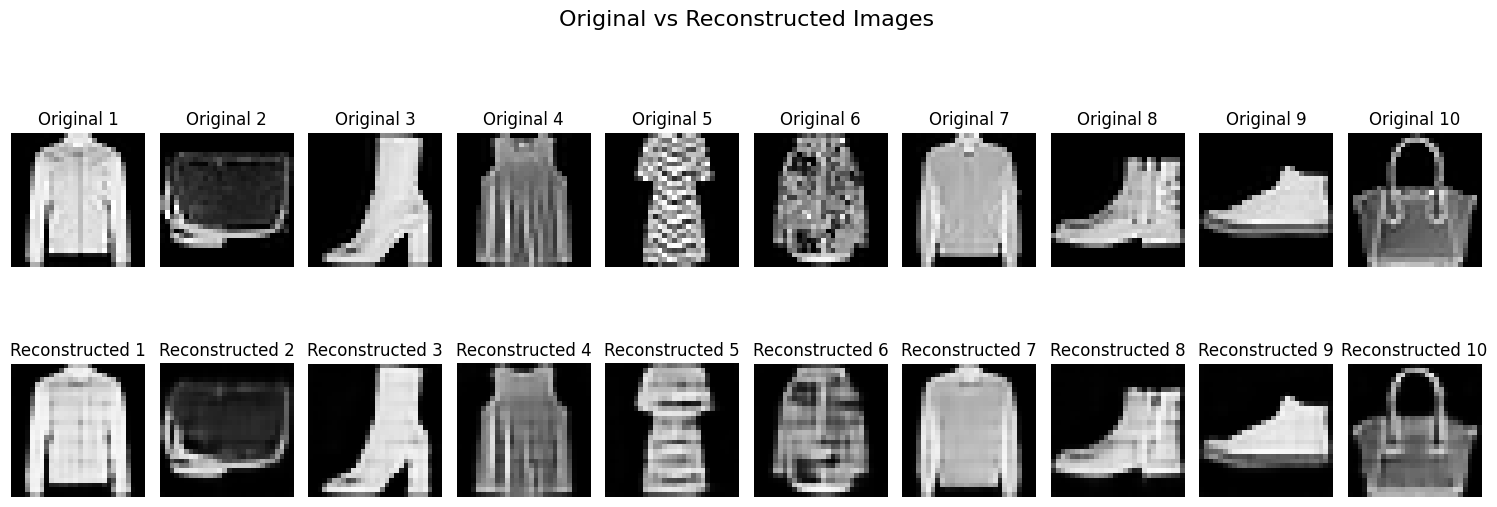

Original image shape: (1, 28, 28)
Reconstructed image shape: (1, 28, 28)


In [9]:

visualize_reconstructions(model, test_loader, num_images=10)


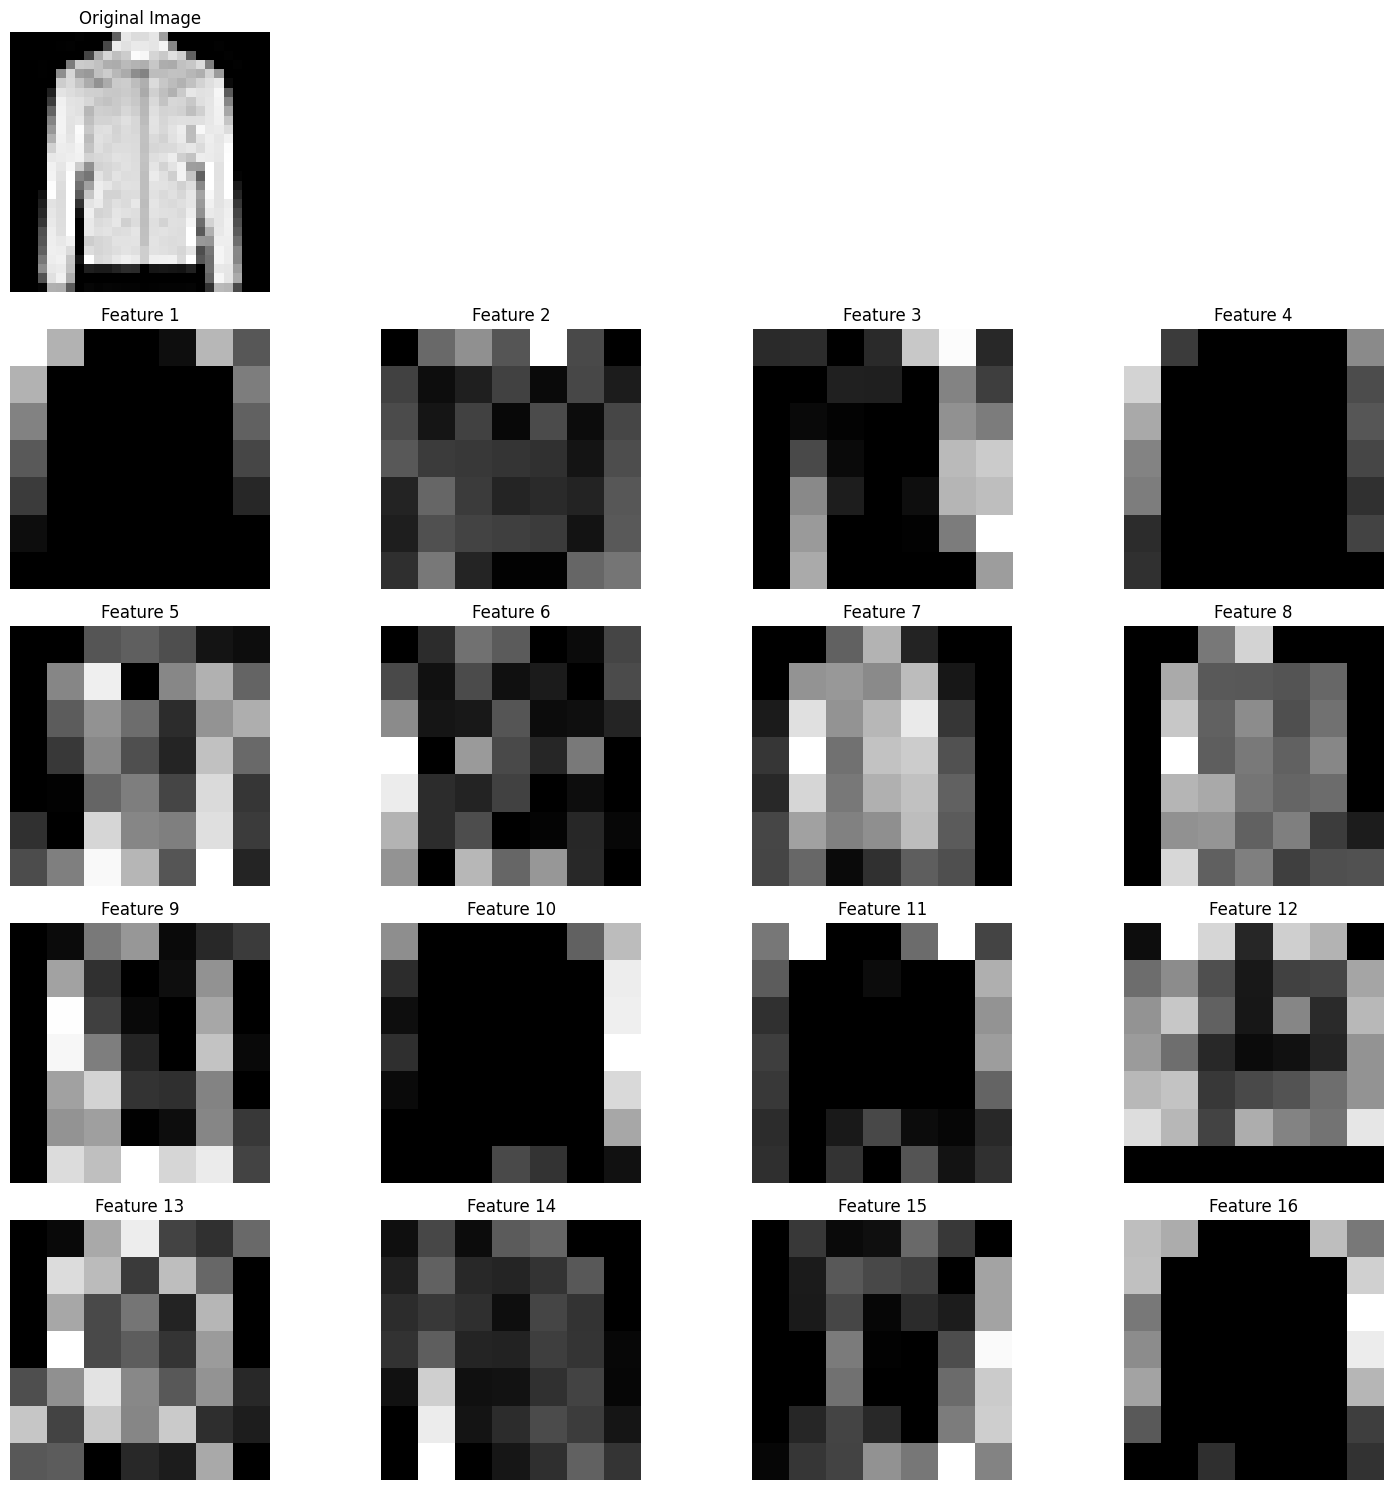

Original image shape: (1, 28, 28)
Encoded representation shape: (32, 7, 7)


In [10]:
from sklearn.decomposition import PCA

def visualize_encoded(model, test_loader, num_images=5):
    """
    Visualize original images and their encoded feature representations
    """
    model.eval()
    device = next(model.parameters()).device
    
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    images = images[:num_images]
    images = images.to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        encoded = model.encode(images)
    
    images = images.cpu().numpy()
    encoded = encoded.cpu().numpy()
    
    # Create a figure with two rows: originals and feature maps
    fig = plt.figure(figsize=(15, 6))
    
    # Plot original images in the first row
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f'Original {i+1}')
    
    # Plot encoded features in the second row
    # We'll show the average activation across all channels
    for i in range(num_images):
        plt.subplot(2, num_images, num_images + i + 1)
        # Average across channels to get a single representative feature map
        feature_map = np.mean(encoded[i], axis=0)
        plt.imshow(feature_map, cmap='viridis')  # Using viridis colormap for feature visualization
        plt.axis('off')
        plt.title(f'Encoded Features\n(avg of {encoded[i].shape[0]} channels)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original image shape: {images[0].shape}")
    print(f"Encoded representation shape: {encoded[0].shape}")

def visualize_encoded_detailed(model, test_loader, num_images=1, max_features=16):
    """
    Visualize original image and multiple channels of its encoded representation
    """
    model.eval()
    device = next(model.parameters()).device
    
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    images = images[:num_images]
    images = images.to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        encoded = model.encode(images)
    
    images = images.cpu().numpy()
    encoded = encoded.cpu().numpy()
    
    for img_idx in range(num_images):
        # Calculate grid size for feature maps
        n_features = min(encoded.shape[1], max_features)
        grid_size = int(np.ceil(np.sqrt(n_features)))
        
        # Create figure
        fig = plt.figure(figsize=(15, 15))
        
        # Plot original image
        plt.subplot(grid_size + 1, grid_size, 1)
        plt.imshow(images[img_idx].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.title('Original Image')
        
        # Plot individual feature maps
        for feat_idx in range(n_features):
            plt.subplot(grid_size + 1, grid_size, feat_idx + grid_size + 1)
            plt.imshow(encoded[img_idx, feat_idx], cmap='gray')
            plt.axis('off')
            plt.title(f'Feature {feat_idx + 1}')
        
        plt.tight_layout()
        plt.show()
        
    print(f"Original image shape: {images[0].shape}")
    print(f"Encoded representation shape: {encoded[0].shape}")
    
visualize_encoded_detailed(model,test_loader)

#### 4.2.3.2 
Create a plot of the encoded representations in the latent space to analyze
how well different classes are clustered or separated. For this, you can
make use of sklearn PCA to reduce the dimensionality for visualization.
Plot both 2D and 3D representations. Mention any observations you can
make. (10 Marks)

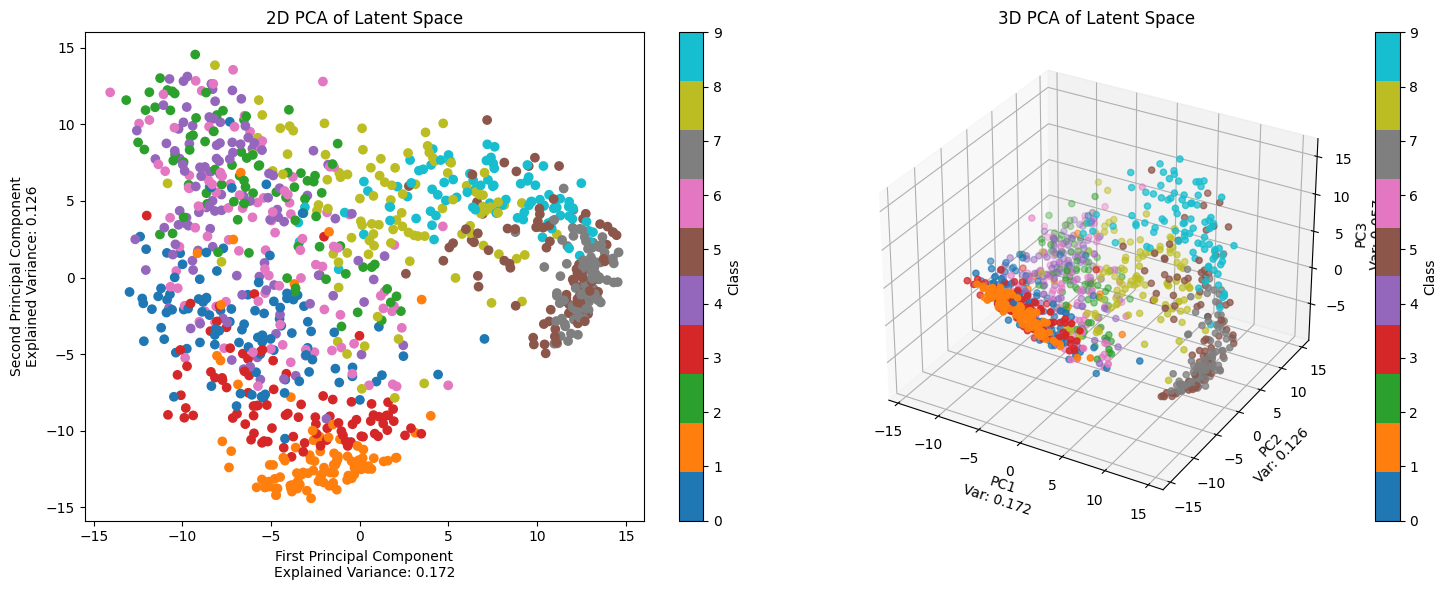


Explained Variance Ratios:
2D PCA: [0.17233707 0.12619261]
Total variance explained (2D): 0.299
3D PCA: [0.17233703 0.12619269 0.05737279]
Total variance explained (3D): 0.356
All the eigenvalues = [0.172337   0.12619248 0.05737262 0.04375973 0.03993885 0.02714287
 0.02640101 0.02225365 0.01985836 0.01560852 0.01351074 0.01230325
 0.01143426 0.01127287 0.01018885 0.0091155  0.00820199 0.0079505
 0.007636   0.00719689 0.00666862 0.00645292 0.0061767  0.00614506
 0.005826   0.00546687 0.00528714 0.00517955 0.00494106 0.00475279
 0.00450576 0.00427876]


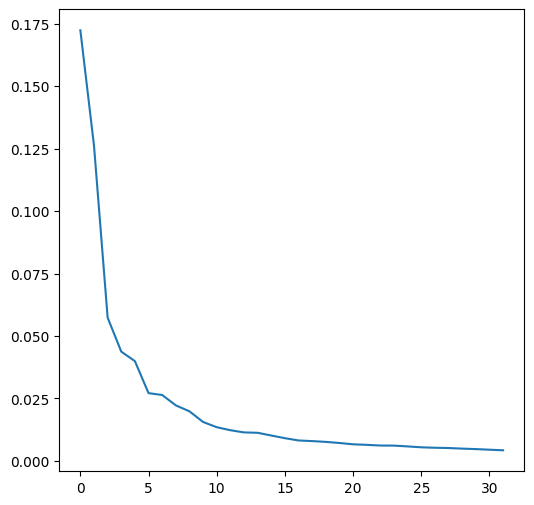

In [11]:
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_latent_space(model, test_loader, n_samples=1000):
    """
    Visualize the latent space representations using PCA for both 2D and 3D plots
    """
    model.eval()
    device = next(model.parameters()).device
    
    encoded_samples = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in test_loader:

            if len(encoded_samples) * images.shape[0] >= n_samples:
                break
                
            images = images.to(device)
            images = images / 255.0 if images.max() > 1 else images
            
            encoded = model.encode(images)
            
            batch_size = encoded.shape[0]
            flattened = encoded.reshape(batch_size, -1)
            
            encoded_samples.append(flattened.cpu().numpy())
            labels.extend(batch_labels.numpy())
    
    encoded_samples = np.concatenate(encoded_samples, axis=0)[:n_samples]
    labels = np.array(labels[:n_samples])
    
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    pca_max = PCA(n_components=32)
    
    encoded_2d = pca_2d.fit_transform(encoded_samples)
    encoded_3d = pca_3d.fit_transform(encoded_samples)
    encoded_max = pca_max.fit_transform(encoded_samples)
    
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, cmap='tab10')
    ax1.set_title('2D PCA of Latent Space')
    ax1.set_xlabel(f'First Principal Component\nExplained Variance: {pca_2d.explained_variance_ratio_[0]:.3f}')
    ax1.set_ylabel(f'Second Principal Component\nExplained Variance: {pca_2d.explained_variance_ratio_[1]:.3f}')
    plt.colorbar(scatter, ax=ax1, label='Class')
    
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(encoded_3d[:, 0], encoded_3d[:, 1], encoded_3d[:, 2], 
                         c=labels, cmap='tab10')
    ax2.set_title('3D PCA of Latent Space')
    ax2.set_xlabel(f'PC1\nVar: {pca_3d.explained_variance_ratio_[0]:.3f}')
    ax2.set_ylabel(f'PC2\nVar: {pca_3d.explained_variance_ratio_[1]:.3f}')
    ax2.set_zlabel(f'PC3\nVar: {pca_3d.explained_variance_ratio_[2]:.3f}')
    plt.colorbar(scatter, ax=ax2, label='Class')
    
    plt.tight_layout()
    plt.show()
    
    print("\nExplained Variance Ratios:")
    print(f"2D PCA: {pca_2d.explained_variance_ratio_}")
    print(f"Total variance explained (2D): {sum(pca_2d.explained_variance_ratio_):.3f}")
    print(f"3D PCA: {pca_3d.explained_variance_ratio_}")
    print(f"Total variance explained (3D): {sum(pca_3d.explained_variance_ratio_):.3f}")
    
    print(f"All the eigenvalues = {pca_max.explained_variance_ratio_}")
    
    plt.figure(figsize =(6,6))
    plt.plot(pca_max.explained_variance_ratio_)
    plt.show()
    
    return pca_2d, pca_3d, encoded_2d, encoded_3d, labels

    
pca_2d, pca_3d, encoded_2d, encoded_3d, labels = visualize_latent_space(model, train_loader)


In the 3D space labels 6 and 2 which makes sense as pretty mixed as pullovers and shirts are hard to differentiate,Even 7 and 5 are mixed, it makes sense as both and footwear(similar)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Train Loss: 0.009423, Val Loss: 0.003019
Epoch [2/10], Train Loss: 0.002735, Val Loss: 0.002157
Epoch [3/10], Train Loss: 0.002029, Val Loss: 0.001607
Epoch [4/10], Train Loss: 0.001806, Val Loss: 0.001322
Epoch [5/10], Train Loss: 0.001412, Val Loss: 0.001480
Epoch [6/10], Train Loss: 0.001357, Val Loss: 0.001090
Epoch [7/10], Train Loss: 0.001181, Val Loss: 0.001018
Epoch [8/10], Train Loss: 0.001117, Val Loss: 0.000902
Epoch [9/10], Train Loss: 0.001028, Val Loss: 0.000892
Epoch [10/10], Train Loss: 0.000976, Val Loss: 0.000838


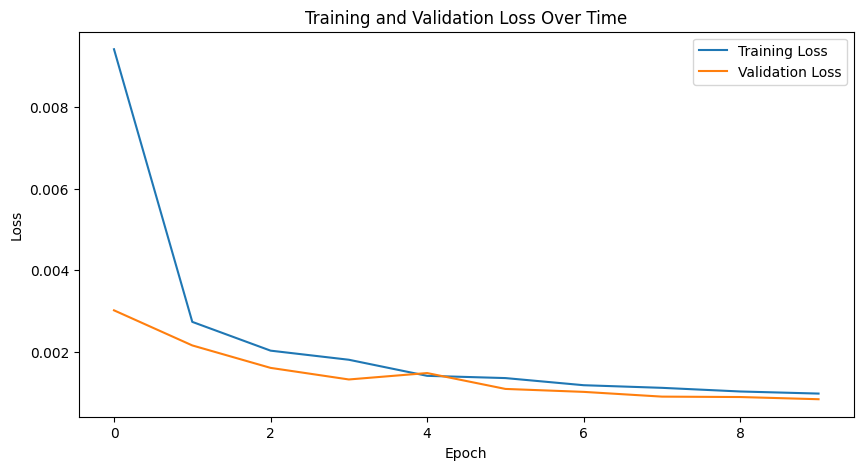

0.0008125690097409872


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class AutoEncoder(nn.Module):
    def __init__(self, kernel_size=3, num_layers=3, initial_channels=32, optimizer_type='adam'):
        super(AutoEncoder, self).__init__()
        
        self.padding = (kernel_size - 1) // 2
        self.optimizer_type = optimizer_type  
        
        encoder_layers = []
        in_channels = 1
        current_channels = initial_channels
        
        for i in range(num_layers):

            encoder_layers.extend([
                nn.Conv2d(in_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU(),

                nn.Conv2d(current_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU()
            ])
            
            if i < num_layers - 1:
                encoder_layers.append(nn.MaxPool2d(2, 2))
                in_channels = current_channels
                current_channels *= 2
        
        self.encoder = nn.Sequential(*encoder_layers)
        

        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):

            current_out_channels = initial_channels * (2 ** max(i-1, 0))
            current_in_channels = initial_channels * (2 ** i)
            
            if i == num_layers - 1:
                current_in_channels = current_channels
            

            decoder_layers.extend([
                nn.ConvTranspose2d(current_in_channels, current_out_channels, 
                                 kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_out_channels),
                nn.ReLU()
            ])
            

            if i > 0:
                decoder_layers.append(nn.Upsample(scale_factor=2))
            

            if i == 0:
                decoder_layers.extend([
                    nn.ConvTranspose2d(current_out_channels, 1, 
                                     kernel_size=kernel_size, padding=self.padding),
                    nn.Sigmoid()
                ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        

        self.output_size = 28 // (2 ** (num_layers - 1))
        assert self.output_size * (2 ** (num_layers - 1)) == 28, \
            f"Number of layers ({num_layers}) will not maintain 28x28 dimensions"
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        device = next(self.parameters()).device
        criterion = nn.MSELoss()
        

        if self.optimizer_type == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
        elif self.optimizer_type == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):

            self.train()
            epoch_loss = 0
            batch_count = 0
            
            for data, _ in train_loader:
                data = data.to(device)
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
                
#                 if batch_count % 100 == 0:
#                     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_count}], Loss: {loss.item():.6f}")
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    data = data / 255.0 if data.max() > 1 else data
                    reconstructed, _ = self(data)
                    val_loss += criterion(reconstructed, data).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            
            scheduler.step(avg_val_loss)
        
        # Plot training and validation losses
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        return train_losses, val_losses


def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        reconstructed, _ = model(images)
    
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Original vs Reconstructed Images', fontsize=16)
    
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')
    
    plt.tight_layout()
    plt.show()

    
def calculate_test_loss(model, test_loader, criterion=None):
    """
    Calculate the loss on a test dataset.
    
    Args:
        model (ModularAutoencoder): The trained autoencoder model
        test_loader (DataLoader): DataLoader containing the test dataset
        criterion (nn.Module, optional): Loss function to use. Defaults to MSELoss if None
        
    Returns:
        tuple: (average_loss, batch_losses)
            - average_loss (float): The average loss across all test batches
            - batch_losses (list): List of individual batch losses
    """
    if criterion is None:
        criterion = nn.MSELoss()
    
    device = next(model.parameters()).device
    model.eval()
    
    total_loss = 0
    batch_losses = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            # Normalize data if needed
            data = data / 255.0 if data.max() > 1 else data
            
            # Forward pass
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data).item()
            
            batch_losses.append(loss)
            total_loss += loss
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, batch_losses

model = AutoEncoder(
    kernel_size=3,      # Kernel size for all convolutions
    num_layers=2,       # Number of encoder/decoder blocks
    initial_channels=32 # Initial number of channels (doubles with each layer)
).to(device)


train_losses, val_losses = model.train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=0.001
)

avg_loss, batch_loss = calculate_test_loss(model,test_loader)
print(avg_loss)

# visualize_reconstructions(model, test_loader)

### 4.2.4 Hyperparameter tuning

performed hyperparameter tuning with varying layers and and filters per layer too.
![image1](figures/image.png)

The best model has num_conv_layers = 2, kernel_size = 3, initial_channels = 64, learning rate = 0.001, epochs  = 10,optimizer = 'adam' 

![image2](figures/image2.png)
![image2](figures/image3.png)
![image2](figures/image4.png)
![image2](figures/image5.png)


In [13]:
# import wandb
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()

# my_secret = user_secrets.get_secret("wandb_api_key") 

# wandb.login(key=my_secret)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class AutoEncoder(nn.Module):
    def __init__(self, kernel_size=3, num_layers=3, initial_channels=32, optimizer_type='adam'):
        super(AutoEncoder, self).__init__()
        
        self.padding = (kernel_size - 1) // 2
        self.optimizer_type = optimizer_type  # Save optimizer type for later use
        
        # Create encoder layers
        encoder_layers = []
        in_channels = 1
        current_channels = initial_channels
        
        for i in range(num_layers):
            # First conv layer in the block
            encoder_layers.extend([
                nn.Conv2d(in_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU(),
                # Second conv layer in the block
                nn.Conv2d(current_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU()
            ])
            
            # Add pooling if not the last layer
            if i < num_layers - 1:
                encoder_layers.append(nn.MaxPool2d(2, 2))
                in_channels = current_channels
                current_channels *= 2
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Create decoder layers
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            # Calculate channels for this layer
            current_out_channels = initial_channels * (2 ** max(i-1, 0))
            current_in_channels = initial_channels * (2 ** i)
            
            if i == num_layers - 1:
                current_in_channels = current_channels
            
            # First conv layer in the block
            decoder_layers.extend([
                nn.ConvTranspose2d(current_in_channels, current_out_channels, 
                                 kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_out_channels),
                nn.ReLU()
            ])
            
            # Add upsampling if not the first layer
            if i > 0:
                decoder_layers.append(nn.Upsample(scale_factor=2))
            
            # Final layer to output single channel
            if i == 0:
                decoder_layers.extend([
                    nn.ConvTranspose2d(current_out_channels, 1, 
                                     kernel_size=kernel_size, padding=self.padding),
                    nn.Sigmoid()
                ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Calculate output size for verification
        self.output_size = 28 // (2 ** (num_layers - 1))
        assert self.output_size * (2 ** (num_layers - 1)) == 28, \
            f"Number of layers ({num_layers}) will not maintain 28x28 dimensions"
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        device = next(self.parameters()).device
        criterion = nn.MSELoss()
        
        # Select optimizer based on the optimizer_type specified
        if self.optimizer_type == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
        elif self.optimizer_type == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # Training phase
            self.train()
            epoch_loss = 0
            batch_count = 0
            
            for data, _ in train_loader:
                data = data.to(device)
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
                
#                 if batch_count % 100 == 0:
#                     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_count}], Loss: {loss.item():.6f}")
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    data = data / 255.0 if data.max() > 1 else data
                    reconstructed, _ = self(data)
                    val_loss += criterion(reconstructed, data).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            
            scheduler.step(avg_val_loss)
            
            wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "epoch": epoch + 1,
            })
        
#         # Plot training and validation losses
#         plt.figure(figsize=(10, 5))
#         plt.plot(train_losses, label='Training Loss')
#         plt.plot(val_losses, label='Validation Loss')
#         plt.title('Training and Validation Loss Over Time')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.show()
        
        return train_losses, val_losses


def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        reconstructed, _ = model(images)
    
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Original vs Reconstructed Images', fontsize=16)
    
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')
    
    plt.tight_layout()
    plt.show()

    
def calculate_test_loss(model, test_loader, criterion=None):
    """
    Calculate the loss on a test dataset.
    
    Args:
        model (ModularAutoencoder): The trained autoencoder model
        test_loader (DataLoader): DataLoader containing the test dataset
        criterion (nn.Module, optional): Loss function to use. Defaults to MSELoss if None
        
    Returns:
        tuple: (average_loss, batch_losses)
            - average_loss (float): The average loss across all test batches
            - batch_losses (list): List of individual batch losses
    """
    if criterion is None:
        criterion = nn.MSELoss()
    
    device = next(model.parameters()).device
    model.eval()
    
    total_loss = 0
    batch_losses = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            # Normalize data if needed
            data = data / 255.0 if data.max() > 1 else data
            
            # Forward pass
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data).item()
            
            batch_losses.append(loss)
            total_loss += loss
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, batch_losses


In [15]:
# import wandb

# # sweep_config = {
# #     'method': 'grid',
# #     'metric': {
# #         'name': 'val_loss', 
# #         'goal': 'minimize'
# #     },
# #     'parameters': {
# #         'learning_rate': {'values': [1e-3, 1e-4]},
# #         'kernel_size': {'values': [3, 5, 7]},
# #         'num_layers': {'values': [2, 3]},
# #         'initial_channels': {'values': [64]},
# #         'optimizer': {'values': ['adam', 'sgd']}
# #     }
# # }

# sweep_config = {
#     'method': 'grid',
#     'metric': {
#         'name': 'val_loss', 
#         'goal': 'minimize'
#     },
#     'parameters': {
#         'learning_rate': {'values': [1e-4]},
#         'kernel_size': {'values': [3, 5, 7]},
#         'num_layers': {'values': [2, 3]},
#         'initial_channels': {'values': [16, 32, 64]},
#         'optimizer': {'values': ['adam', 'sgd']}
#     }
# }

# def train_sweep():
#     wandb.init()
#     config = wandb.config
    
#     model = AutoEncoder(
#         kernel_size=config.kernel_size,
#         num_layers=config.num_layers,
#         initial_channels=config.initial_channels,
#         optimizer_type=config.optimizer
#     ).to(device)

#     train_losses, val_losses = model.train_model(
#         train_loader=train_loader,
#         val_loader=val_loader,
#         num_epochs=20,
#         learning_rate=config.learning_rate
#     )

#     test_loss, _ = calculate_test_loss(model, test_loader)
    
#     wandb.log({
#         "final_train_loss": train_losses[-1],
#         "final_val_loss": val_losses[-1],
#         "final_test_loss": test_loss,
#         "learning_rate": config.learning_rate,
#         "num_conv_layers": config.num_layers,
#         "optimizer": config.optimizer,
#         "device": str(device)
#     })

# sweep_id = wandb.sweep(sweep_config, project="CNNAutoEncoder_Tuning")
# wandb.agent(sweep_id, train_sweep)

### 4.3 MLP Autoencoder (15 Marks)

Epoch [1/20], Train Loss: 0.071159, Val Loss: 0.038831
Epoch [2/20], Train Loss: 0.035425, Val Loss: 0.029919
Epoch [3/20], Train Loss: 0.029890, Val Loss: 0.026250
Epoch [4/20], Train Loss: 0.027539, Val Loss: 0.024009
Epoch [5/20], Train Loss: 0.025848, Val Loss: 0.022961
Epoch [6/20], Train Loss: 0.024438, Val Loss: 0.021874
Epoch [7/20], Train Loss: 0.023439, Val Loss: 0.020973
Epoch [8/20], Train Loss: 0.022546, Val Loss: 0.020105
Epoch [9/20], Train Loss: 0.021767, Val Loss: 0.019612
Epoch [10/20], Train Loss: 0.020941, Val Loss: 0.019259
Epoch [11/20], Train Loss: 0.020457, Val Loss: 0.018533
Epoch [12/20], Train Loss: 0.020081, Val Loss: 0.018329
Epoch [13/20], Train Loss: 0.019562, Val Loss: 0.018363
Epoch [14/20], Train Loss: 0.019314, Val Loss: 0.017601
Epoch [15/20], Train Loss: 0.018803, Val Loss: 0.017197
Epoch [16/20], Train Loss: 0.018486, Val Loss: 0.016983
Epoch [17/20], Train Loss: 0.018275, Val Loss: 0.016966
Epoch [18/20], Train Loss: 0.017907, Val Loss: 0.016702
E

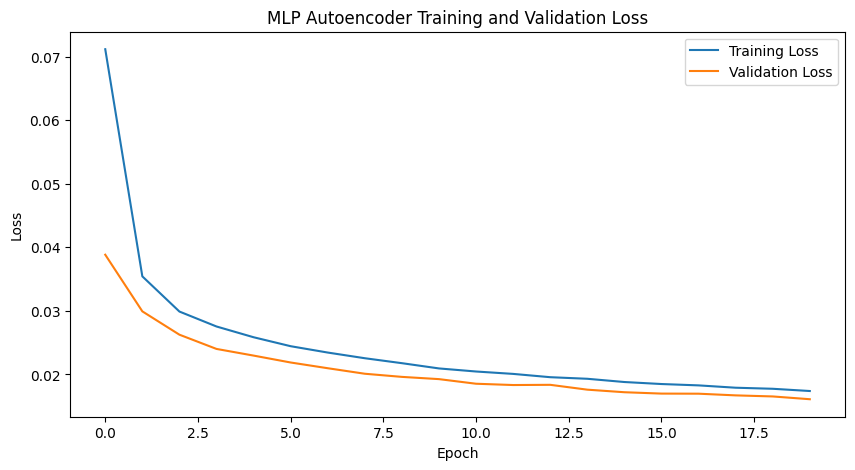

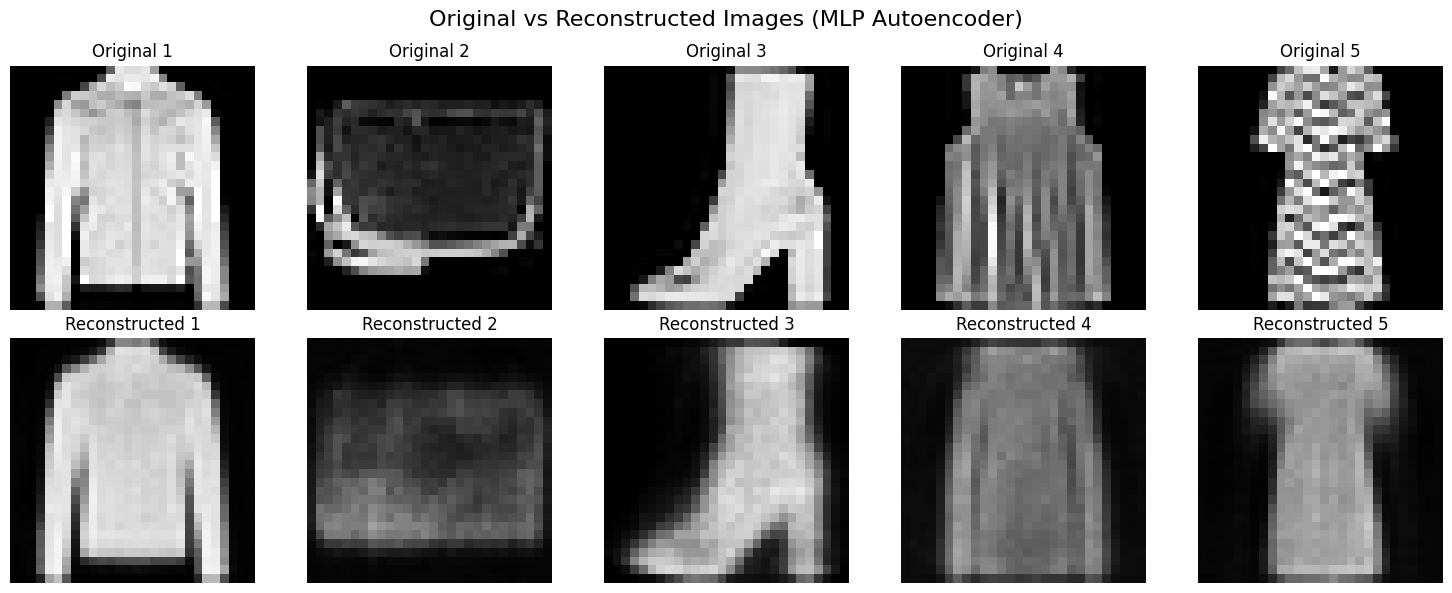

MLP Autoencoder Test Loss: 0.015974


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MLPAutoEncoder(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], optimizer_type='adam'):
        super(MLPAutoEncoder, self).__init__()
        
        self.input_size = input_size
        self.optimizer_type = optimizer_type
        
        # Create encoder layers
        encoder_layers = []
        current_size = input_size
        
        for hidden_size in hidden_sizes:
            encoder_layers.extend([
                nn.Linear(current_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            ])
            current_size = hidden_size
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Create decoder layers
        decoder_layers = []
        hidden_sizes_reversed = hidden_sizes[::-1]
        
        for i in range(len(hidden_sizes_reversed)):
            current_in_size = hidden_sizes_reversed[i]
            current_out_size = input_size if i == len(hidden_sizes_reversed)-1 else hidden_sizes_reversed[i+1]
            
            if i == len(hidden_sizes_reversed)-1:
                # Final layer uses Sigmoid activation
                decoder_layers.extend([
                    nn.Linear(current_in_size, current_out_size),
                    nn.Sigmoid()
                ])
            else:
                decoder_layers.extend([
                    nn.Linear(current_in_size, current_out_size),
                    nn.BatchNorm1d(current_out_size),
                    nn.ReLU()
                ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        # Flatten the input
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Forward pass through encoder and decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # Reshape back to image dimensions
        decoded = decoded.view(batch_size, 1, 28, 28)
        return decoded, encoded

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        device = next(self.parameters()).device
        criterion = nn.MSELoss()
        
        # Select optimizer based on the optimizer_type specified
        if self.optimizer_type == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
        elif self.optimizer_type == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # Training phase
            self.train()
            epoch_loss = 0
            
            for data, _ in train_loader:
                data = data.to(device)
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    data = data / 255.0 if data.max() > 1 else data
                    reconstructed, _ = self(data)
                    val_loss += criterion(reconstructed, data).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            
            scheduler.step(avg_val_loss)
            
#             # Log metrics
#             wandb.log({
#                 "train_loss": avg_train_loss,
#                 "val_loss": avg_val_loss,
#                 "epoch": epoch + 1,
#             })
        
        return train_losses, val_losses

def visualize_reconstructions_mlp(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        reconstructed, _ = model(images)
    
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Original vs Reconstructed Images (MLP Autoencoder)', fontsize=16)
    
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')
    
    plt.tight_layout()
    plt.show()

def calculate_test_loss_mlp(model, test_loader, criterion=None):
    if criterion is None:
        criterion = nn.MSELoss()
    
    device = next(model.parameters()).device
    model.eval()
    
    total_loss = 0
    batch_losses = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            data = data / 255.0 if data.max() > 1 else data
            
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data).item()
            
            batch_losses.append(loss)
            total_loss += loss
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, batch_losses


mlp_autoencoder = MLPAutoEncoder(
    input_size=784,  # 28x28 flattened
    hidden_sizes=[512, 256, 128, 64],  # Decrease dimensions gradually
    optimizer_type='adam'
).to(device)

# Train the model
train_losses, val_losses = mlp_autoencoder.train_model(
    train_loader,
    val_loader,
    num_epochs=20,
    learning_rate=0.0001
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('MLP Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize reconstructions
visualize_reconstructions_mlp(mlp_autoencoder, test_loader, num_images=5)

# Calculate test loss
test_loss, _ = calculate_test_loss_mlp(mlp_autoencoder, test_loader)
print(f"MLP Autoencoder Test Loss: {test_loss:.6f}")

### 4.4 PCA Autoencoder

In [17]:
import numpy as np

class PcaAutoencoder:
    def __init__(self, n_components):
        """
        Initialize PCA Autoencoder with specified number of components
        
        Args:
            n_components (int): Number of principal components to use
        """
        self.n_components = n_components
        self.eigenvectors = None
        self.mean = None
        self.eigenvalues = None
        
    def fit(self, X):
        """
        Calculate eigenvalues and eigenvectors from the input data
        
        Args:
            X (np.ndarray): Input data matrix of shape (n_samples, n_features)
        """
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        cov_matrix = np.cov(X_centered.T)
        
        self.eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = eigenvectors[:, idx]
        
        self.eigenvectors = self.eigenvectors[:, :self.n_components]
        
    def encode(self, X):
        """
        Reduce dimensionality of input data using learned eigenvectors
        
        Args:
            X (np.ndarray): Input data matrix of shape (n_samples, n_features)
            
        Returns:
            np.ndarray: Encoded data with reduced dimensions
        """
        X_centered = X - self.mean
        
        return np.dot(X_centered, self.eigenvectors)
    
    def forward(self, X):
        """
        Reconstruct the input data from its encoded representation
        
        Args:
            X (np.ndarray): Input data matrix of shape (n_samples, n_features)
            
        Returns:
            np.ndarray: Reconstructed data in original dimension
        """
        encoded = self.encode(X)
        
        reconstructed = np.dot(encoded, self.eigenvectors.T) + self.mean
        
        return reconstructed
    
    def reconstruction_error(self, X):
        """
        Calculate reconstruction error (MSE) for the input data
        
        Args:
            X (np.ndarray): Input data matrix
            
        Returns:
            float: Mean squared reconstruction error
        """
        reconstructed = self.forward(X)
        return np.mean((X - reconstructed) ** 2)
    
    def explained_variance_ratio(self):
        """
        Calculate the proportion of variance explained by each principal component
        
        Returns:
            np.ndarray: Array of explained variance ratios
        """
        return self.eigenvalues[:self.n_components] / np.sum(self.eigenvalues)

Images shape: torch.Size([26, 1, 28, 28])
Flattened images shape: (26, 784)
Final val_data shape: (2010, 784)


Testing different component numbers: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


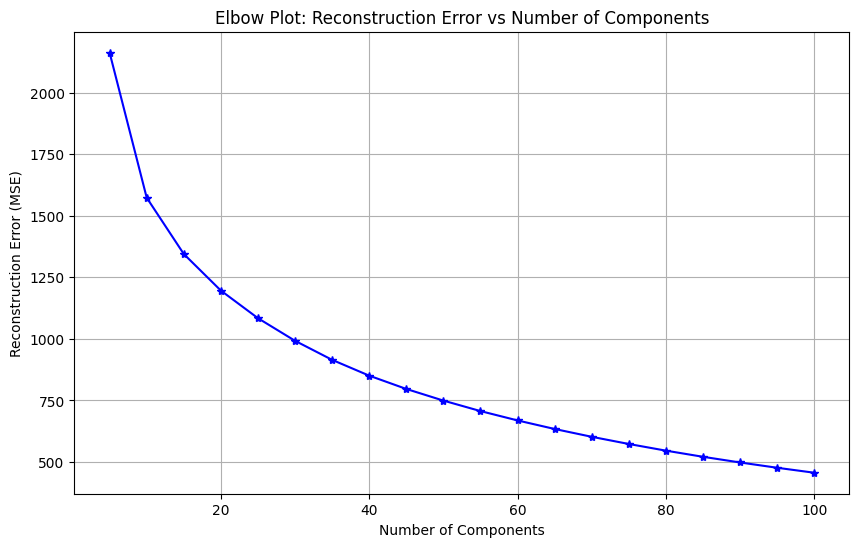

Optimal number of components: 12


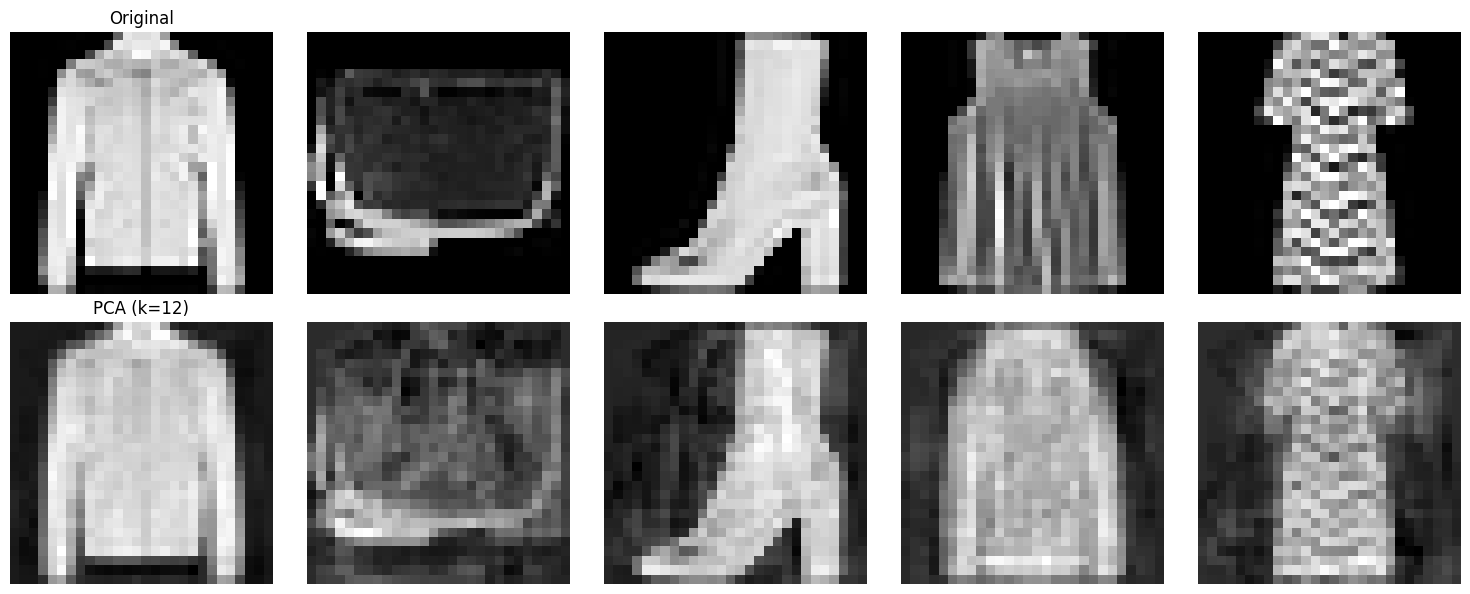

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def find_optimal_components(val_loader, max_components=100, step=1):
    """
    Find optimal number of components using elbow method on validation data
    """
    val_data = []
    for images, _ in val_loader:
        val_data.append(images.numpy().reshape(images.shape[0], -1))
    val_data = np.concatenate(val_data, axis=0)
    
    print("Images shape:", images.shape)
    print("Flattened images shape:", images.numpy().reshape(images.shape[0], -1).shape)
    print("Final val_data shape:", val_data.shape)

    n_components_range = range(step, max_components + step, step)
    reconstruction_errors = []
    
    for n in tqdm(n_components_range, desc="Testing different component numbers"):

        pca_ae = PcaAutoencoder(n_components=n)
        pca_ae.fit(val_data)
        
        error = pca_ae.reconstruction_error(val_data)
        reconstruction_errors.append(error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, reconstruction_errors, 'b-', marker='*')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Elbow Plot: Reconstruction Error vs Number of Components')
    plt.grid(True)
    plt.show()
    
    return reconstruction_errors

def compare_reconstructions(test_loader, k_optimal, cnn_ae=None, mlp_ae=None):
    """
    Compare original images with reconstructions from different autoencoders
    """

    test_images, _ = next(iter(test_loader))
    test_data = test_images.numpy().reshape(test_images.shape[0], -1)
    

    pca_ae = PcaAutoencoder(n_components=k_optimal)
    pca_ae.fit(test_data)
    pca_reconstructed = pca_ae.forward(test_data)
    

    original_images = test_images.numpy()
    pca_reconstructed = pca_reconstructed.reshape(original_images.shape)
    

    n_images = min(5, test_images.shape[0])
    fig, axes = plt.subplots(2, n_images, 
                            figsize=(15,6))
    
    for i in range(n_images):

        axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
            
        axes[1, i].imshow(pca_reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title(f'PCA (k={k_optimal})')
    
    plt.tight_layout()
    plt.show()

    
if __name__ == "__main__":

    errors = find_optimal_components(val_loader, max_components=100, step=5)
    print(f"Optimal number of components: {12}")
    
    
    compare_reconstructions(test_loader, 12)
    

### 4.5 KNN Classification (30 Marks)

![image](figures/image%20copy%209.png)

This is the comparision of the output of KNN after the encoding of the three schemes latent dimensions = k_optimal which in my case is 12.

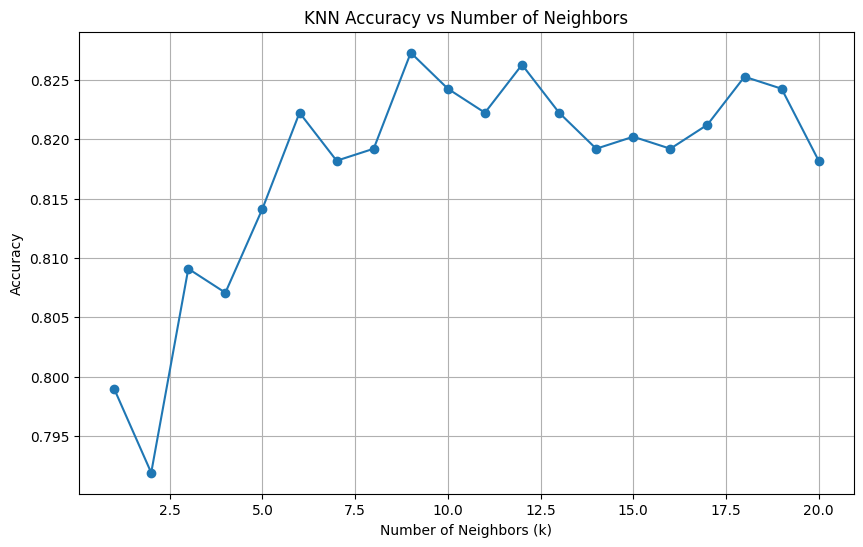

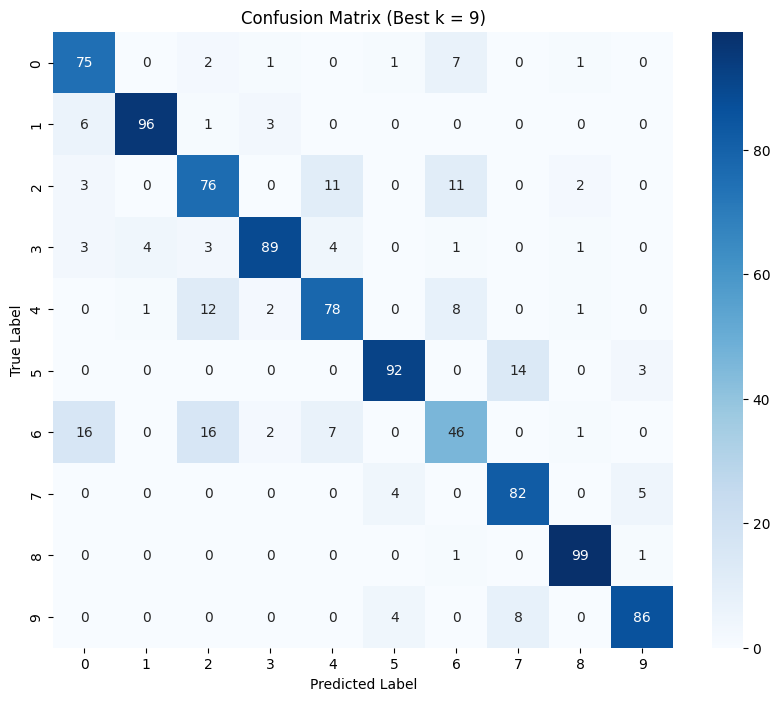

Best k: 9
Best Accuracy: 0.8273

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        87
           1       0.95      0.91      0.93       106
           2       0.69      0.74      0.71       103
           3       0.92      0.85      0.88       105
           4       0.78      0.76      0.77       102
           5       0.91      0.84      0.88       109
           6       0.62      0.52      0.57        88
           7       0.79      0.90      0.84        91
           8       0.94      0.98      0.96       101
           9       0.91      0.88      0.89        98

    accuracy                           0.83       990
   macro avg       0.82      0.82      0.82       990
weighted avg       0.83      0.83      0.83       990



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import seaborn as sns

def extract_data_and_labels(dataloader):
    """
    Extract data and labels from a PyTorch DataLoader
    
    Args:
        dataloader (torch.utils.data.DataLoader): Input dataloader
    
    Returns:
        tuple: (data as numpy array, labels as numpy array)
    """
    data_list = []
    labels_list = []
    
    for images, labels in dataloader:
        # Reshape 28x28 images to flat vectors
        data_list.append(images.numpy().reshape(images.shape[0], -1))
        labels_list.append(labels.numpy())
    
    return (np.concatenate(data_list, axis=0), 
            np.concatenate(labels_list, axis=0))

def perform_pca_knn_classification(train_loader, test_loader, n_components=15):
    """
    Perform PCA dimensionality reduction and KNN classification
    
    Args:
        train_loader (torch.utils.data.DataLoader): Training data loader
        test_loader (torch.utils.data.DataLoader): Test data loader
        n_components (int): Number of PCA components to retain
    
    Returns:
        dict: Classification results and analysis
    """
    # Extract data and labels
    X_train, y_train = extract_data_and_labels(train_loader)
    X_test, y_test = extract_data_and_labels(test_loader)
    
    # Initialize and fit PCA Autoencoder
    pca_ae = PcaAutoencoder(n_components=n_components)
    pca_ae.fit(X_train)
    
    # Reduce dimensionality of train and test data
    X_train_reduced = pca_ae.encode(X_train)
    X_test_reduced = pca_ae.encode(X_test)
    
    # Perform KNN classification with different k values
    k_range = range(1, 21)
    accuracies = []
    
    for k in k_range:
        # Create and train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_reduced, y_train)
        
        # Predict and calculate accuracy
        y_pred = knn.predict(X_test_reduced)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Visualize accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), accuracies, marker='o')
    plt.title('KNN Accuracy vs Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # Find best k
    best_k = list(k_range)[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    
    # Detailed analysis with best k
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train_reduced, y_train)
    y_pred_best = best_knn.predict(X_test_reduced)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Best k = {best_k})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Print detailed classification report
    print(f"Best k: {best_k}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best))
    
    return {
        'accuracies': accuracies,
        'best_k': best_k,
        'best_accuracy': best_accuracy
    }

# Example usage in main script
def main():
    # Assuming you have train_loader and test_loader from your previous code
    results = perform_pca_knn_classification(train_loader, test_loader, n_components=15)

if __name__ == "__main__":
    main()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 0.016909, Val Loss: 0.008432
Epoch [2/20], Train Loss: 0.007551, Val Loss: 0.006654
Epoch [3/20], Train Loss: 0.006070, Val Loss: 0.006177
Epoch [4/20], Train Loss: 0.005159, Val Loss: 0.005120
Epoch [5/20], Train Loss: 0.004641, Val Loss: 0.004192
Epoch [6/20], Train Loss: 0.004159, Val Loss: 0.004124
Epoch [7/20], Train Loss: 0.003821, Val Loss: 0.003652
Epoch [8/20], Train Loss: 0.003631, Val Loss: 0.003922
Epoch [9/20], Train Loss: 0.003535, Val Loss: 0.003657
Epoch [10/20], Train Loss: 0.003189, Val Loss: 0.003409
Epoch [11/20], Train Loss: 0.003120, Val Loss: 0.002904
Epoch [12/20], Train Loss: 0.002902, Val Loss: 0.002972
Epoch [13/20], Train Loss: 0.002786, Val Loss: 0.003432
Epoch [14/20], Train Loss: 0.002914, Val Loss: 0.003593
Epoch [15/20], Train Loss: 0.002427, Val Loss: 0.002408
Epoch [16/20], Train Loss: 0.002233, Val Loss: 0.002400
Epoch [17/20], Train Loss: 0.002205, Val Loss: 0.002493
Epoch [18/20], Train Loss: 0.002200, Val Loss: 0.002777
E

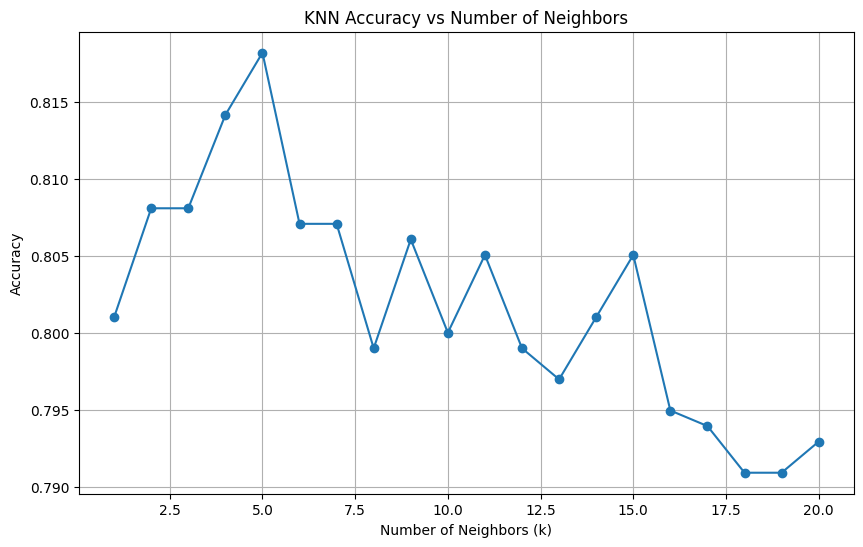

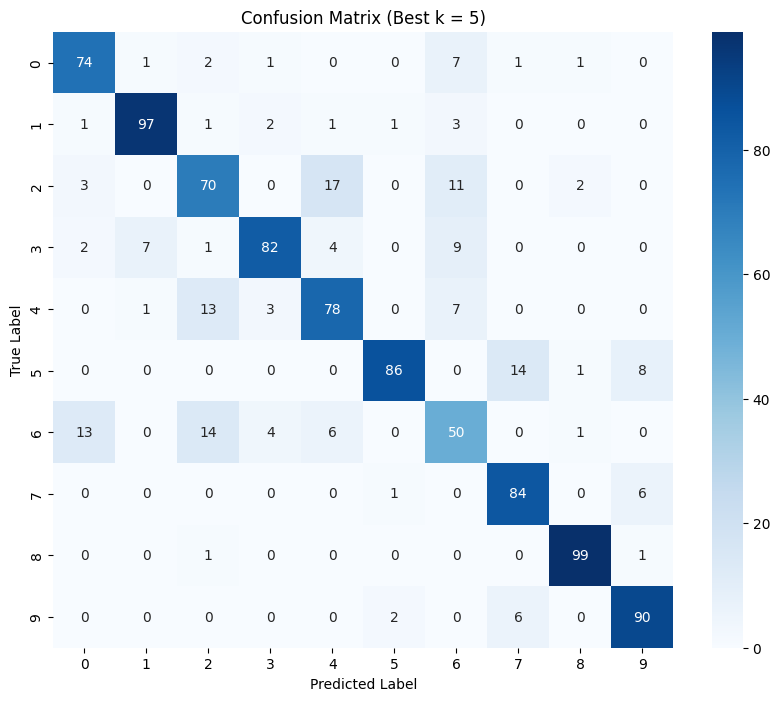

Best k: 5
Best Accuracy: 0.8182

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        87
           1       0.92      0.92      0.92       106
           2       0.69      0.68      0.68       103
           3       0.89      0.78      0.83       105
           4       0.74      0.76      0.75       102
           5       0.96      0.79      0.86       109
           6       0.57      0.57      0.57        88
           7       0.80      0.92      0.86        91
           8       0.95      0.98      0.97       101
           9       0.86      0.92      0.89        98

    accuracy                           0.82       990
   macro avg       0.82      0.82      0.81       990
weighted avg       0.82      0.82      0.82       990



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# AutoEncoder class as provided
class AutoEncoder(nn.Module):
    def __init__(self, kernel_size=3, num_layers=3, initial_channels=32, optimizer_type='adam'):
        super(AutoEncoder, self).__init__()
        
        self.padding = (kernel_size - 1) // 2
        self.optimizer_type = optimizer_type
        
        # Encoder layers
        encoder_layers = []
        in_channels = 1
        current_channels = initial_channels
        
        for i in range(num_layers):
            encoder_layers.extend([
                nn.Conv2d(in_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU(),
                nn.Conv2d(current_channels, current_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_channels),
                nn.ReLU()
            ])
            if i < num_layers - 1:
                encoder_layers.append(nn.MaxPool2d(2, 2))
                in_channels = current_channels
                current_channels *= 2
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder layers
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            current_out_channels = initial_channels * (2 ** max(i-1, 0))
            current_in_channels = initial_channels * (2 ** i)
            
            if i == num_layers - 1:
                current_in_channels = current_channels
            
            decoder_layers.extend([
                nn.ConvTranspose2d(current_in_channels, current_out_channels, kernel_size=kernel_size, padding=self.padding),
                nn.BatchNorm2d(current_out_channels),
                nn.ReLU()
            ])
            
            if i > 0:
                decoder_layers.append(nn.Upsample(scale_factor=2))
            
            if i == 0:
                decoder_layers.extend([
                    nn.ConvTranspose2d(current_out_channels, 1, kernel_size=kernel_size, padding=self.padding),
                    nn.Sigmoid()
                ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Output size check for compatibility with input dimensions
        self.output_size = 28 // (2 ** (num_layers - 1))
        assert self.output_size * (2 ** (num_layers - 1)) == 28, \
            f"Number of layers ({num_layers}) will not maintain 28x28 dimensions"
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        device = next(self.parameters()).device
        criterion = nn.MSELoss()
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5) \
                    if self.optimizer_type == 'adam' else optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses, val_losses = [], []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0
            
            for data, _ in train_loader:
                data = data.to(device)
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    data = data / 255.0 if data.max() > 1 else data
                    reconstructed, _ = self(data)
                    val_loss += criterion(reconstructed, data).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            scheduler.step(avg_val_loss)
        
        return train_losses, val_losses

def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    device = next(model.parameters()).device
    
    images, _ = next(iter(test_loader))
    images = images[:num_images].to(device)
    images = images / 255.0 if images.max() > 1 else images
    
    with torch.no_grad():
        reconstructed, _ = model(images)
    
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Original vs Reconstructed Images', fontsize=16)
    
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed {i+1}')
    
    plt.tight_layout()
    plt.show()

def knn_classification_with_cnn_encoder(train_loader, test_loader, autoencoder, device):
    autoencoder.eval()
    autoencoder.to(device)
    
    X_train_encoded, y_train = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            _, latent = autoencoder(images)
            # Flatten the 4D tensor (batch, channels, height, width) into 2D
            latent = latent.view(latent.size(0), -1)
            X_train_encoded.append(latent.cpu().numpy())
            y_train.append(labels.numpy())
    
    X_train_encoded = np.concatenate(X_train_encoded, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    X_test_encoded, y_test = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            _, latent = autoencoder(images)
            # Flatten the latent vector
            latent = latent.view(latent.size(0), -1)
            X_test_encoded.append(latent.cpu().numpy())
            y_test.append(labels.numpy())
    
    X_test_encoded = np.concatenate(X_test_encoded, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    
    k_range = range(1, 21)
    accuracies = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_encoded, y_train)
        y_pred = knn.predict(X_test_encoded)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), accuracies, marker='o')
    plt.title('KNN Accuracy vs Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    best_k = list(k_range)[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train_encoded, y_train)
    y_pred_best = best_knn.predict(X_test_encoded)
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Best k = {best_k})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f"Best k: {best_k}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best))
    
    return {
        'accuracies': accuracies,
        'best_k': best_k,
        'best_accuracy': best_accuracy,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred_best, output_dict=True)
    }


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    autoencoder = AutoEncoder(kernel_size=3, num_layers=3, initial_channels=32, optimizer_type='adam').to(device)
    
    # Assuming train_loader, val_loader, and test_loader are defined
    train_losses, val_losses = autoencoder.train_model(train_loader, val_loader, num_epochs=20, learning_rate=1e-3)
    print('hello')
    results = knn_classification_with_cnn_encoder(train_loader, test_loader, autoencoder, device)

if __name__ == "__main__":
    main()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 0.072068, Val Loss: 0.038859
Epoch [2/20], Train Loss: 0.035810, Val Loss: 0.030243
Epoch [3/20], Train Loss: 0.030388, Val Loss: 0.026524
Epoch [4/20], Train Loss: 0.027839, Val Loss: 0.024579
Epoch [5/20], Train Loss: 0.025914, Val Loss: 0.022863
Epoch [6/20], Train Loss: 0.024769, Val Loss: 0.021949
Epoch [7/20], Train Loss: 0.023543, Val Loss: 0.021249
Epoch [8/20], Train Loss: 0.022942, Val Loss: 0.020295
Epoch [9/20], Train Loss: 0.021994, Val Loss: 0.019902
Epoch [10/20], Train Loss: 0.021294, Val Loss: 0.019109
Epoch [11/20], Train Loss: 0.020822, Val Loss: 0.018913
Epoch [12/20], Train Loss: 0.020288, Val Loss: 0.018640
Epoch [13/20], Train Loss: 0.019859, Val Loss: 0.018253
Epoch [14/20], Train Loss: 0.019455, Val Loss: 0.018129
Epoch [15/20], Train Loss: 0.019121, Val Loss: 0.017660
Epoch [16/20], Train Loss: 0.018870, Val Loss: 0.017353
Epoch [17/20], Train Loss: 0.018496, Val Loss: 0.016730
Epoch [18/20], Train Loss: 0.018135, Val Loss: 0.016780
E

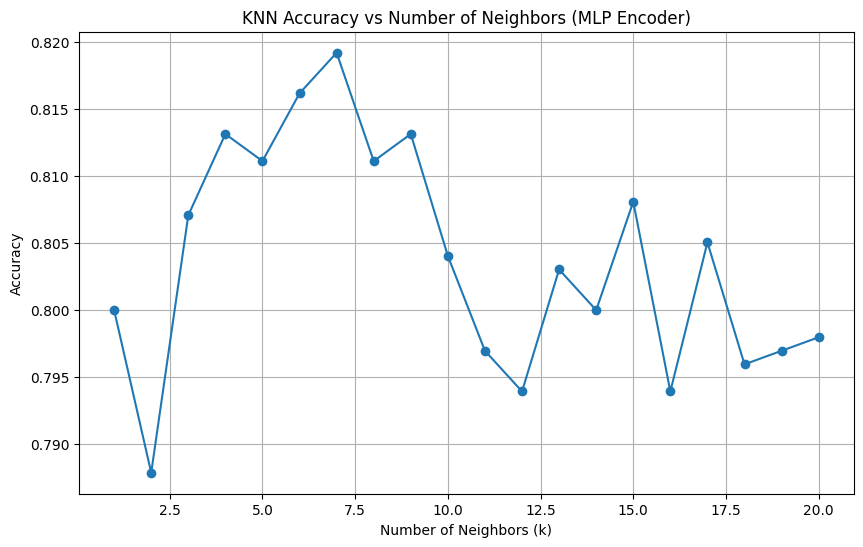

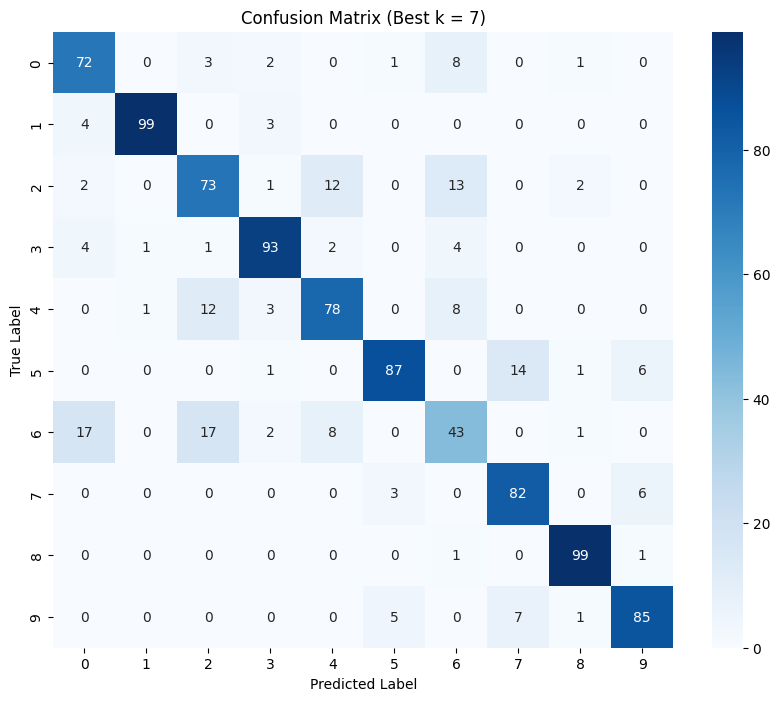

Best k: 7
Best Accuracy: 0.8192

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.77        87
           1       0.98      0.93      0.96       106
           2       0.69      0.71      0.70       103
           3       0.89      0.89      0.89       105
           4       0.78      0.76      0.77       102
           5       0.91      0.80      0.85       109
           6       0.56      0.49      0.52        88
           7       0.80      0.90      0.85        91
           8       0.94      0.98      0.96       101
           9       0.87      0.87      0.87        98

    accuracy                           0.82       990
   macro avg       0.81      0.82      0.81       990
weighted avg       0.82      0.82      0.82       990



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

class MLPAutoEncoder(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128, 64], optimizer_type='adam'):
        super(MLPAutoEncoder, self).__init__()
        
        self.input_size = input_size
        self.optimizer_type = optimizer_type
        
        # Create encoder layers
        encoder_layers = []
        current_size = input_size
        
        for hidden_size in hidden_sizes:
            encoder_layers.extend([
                nn.Linear(current_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            ])
            current_size = hidden_size
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Create decoder layers
        decoder_layers = []
        hidden_sizes_reversed = hidden_sizes[::-1]
        
        for i in range(len(hidden_sizes_reversed)):
            current_in_size = hidden_sizes_reversed[i]
            current_out_size = input_size if i == len(hidden_sizes_reversed)-1 else hidden_sizes_reversed[i+1]
            
            if i == len(hidden_sizes_reversed)-1:
                decoder_layers.extend([
                    nn.Linear(current_in_size, current_out_size),
                    nn.Sigmoid()
                ])
            else:
                decoder_layers.extend([
                    nn.Linear(current_in_size, current_out_size),
                    nn.BatchNorm1d(current_out_size),
                    nn.ReLU()
                ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(batch_size, 1, 28, 28)  # Reshape back to image
        return decoded, encoded

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        device = next(self.parameters()).device
        criterion = nn.MSELoss()
        
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5) \
                    if self.optimizer_type == 'adam' else optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        
        train_losses, val_losses = [], []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0
            for data, _ in train_loader:
                data = data.to(device)
                data = data / 255.0 if data.max() > 1 else data
                
                reconstructed, _ = self(data)
                loss = criterion(reconstructed, data)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    data = data / 255.0 if data.max() > 1 else data
                    reconstructed, _ = self(data)
                    val_loss += criterion(reconstructed, data).item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            scheduler.step(avg_val_loss)
        
        return train_losses, val_losses

def knn_classification_with_mlp_encoder(train_loader, test_loader, autoencoder, device):
    autoencoder.eval()
    autoencoder.to(device)
    
    X_train_encoded, y_train = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            images = images.view(images.size(0), -1)  # Flatten images to 1D
            _, latent = autoencoder(images)
            X_train_encoded.append(latent.cpu().numpy())
            y_train.append(labels.numpy())
    
    X_train_encoded = np.concatenate(X_train_encoded, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    X_test_encoded, y_test = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            images = images.view(images.size(0), -1)  # Flatten images to 1D
            _, latent = autoencoder(images)
            X_test_encoded.append(latent.cpu().numpy())
            y_test.append(labels.numpy())
    
    X_test_encoded = np.concatenate(X_test_encoded, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    
    k_range = range(1, 21)
    accuracies = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_encoded, y_train)
        y_pred = knn.predict(X_test_encoded)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), accuracies, marker='o')
    plt.title('KNN Accuracy vs Number of Neighbors (MLP Encoder)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    best_k = list(k_range)[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train_encoded, y_train)
    y_pred_best = best_knn.predict(X_test_encoded)
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Best k = {best_k})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f"Best k: {best_k}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best))
    
    return {
        'accuracies': accuracies,
        'best_k': best_k,
        'best_accuracy': best_accuracy,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred_best, output_dict=True)
    }

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    mlp_autoencoder = MLPAutoEncoder(
        input_size=784,
        hidden_sizes=[512, 256, 128, 64],
        optimizer_type='adam'
    ).to(device)
    
    # Assuming train_loader, val_loader, and test_loader are defined
    train_losses, val_losses = mlp_autoencoder.train_model(train_loader, val_loader, num_epochs=20, learning_rate=0.0001)
    
    # Perform KNN classification
    results = knn_classification_with_mlp_encoder(train_loader, test_loader, mlp_autoencoder, device)

if __name__ == "__main__":
    main()
